## Digit Detector


In [ ]:
using Images
using Plots
using Revise
using BSON
using Flux
using ImageBinarization

In [ ]:
Revise.includet("../GridDetection/GridDetection.jl")
using .GridDetection
using .GridDetection.PerspectiveTransformations

Revise.includet("../DigitDetection/DigitExtraction.jl")
using .DigitExtraction

## Load image

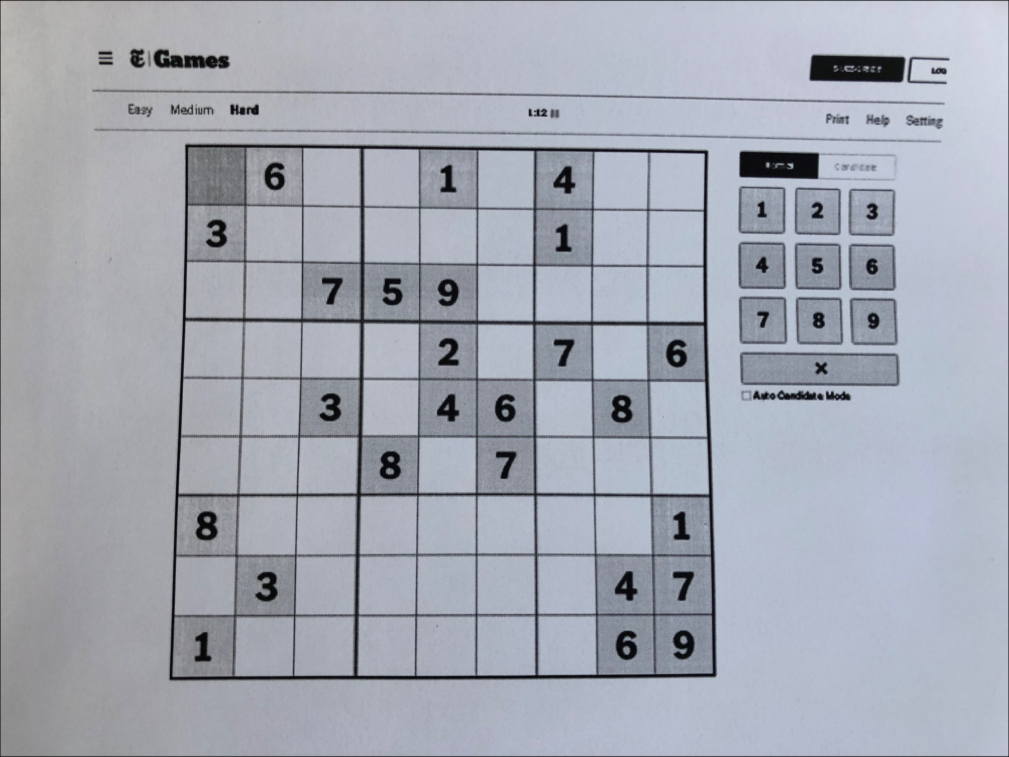

In [ ]:
image_path = "../images/nytimes_20210807.jpg";
image_raw = load(image_path)
image = copy(image_raw)

## Get grid

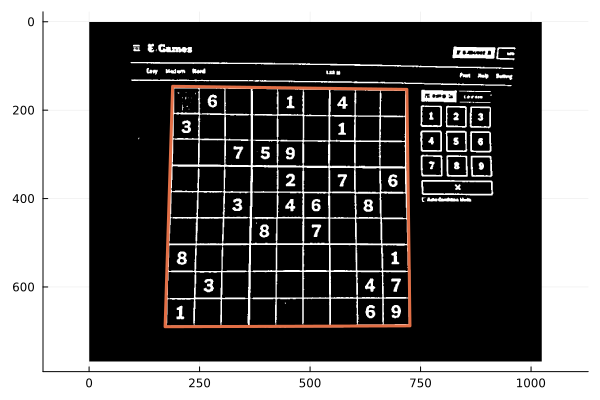

In [ ]:
blackwhite, quad = detect_grid(image);
canvas = plot(blackwhite)

x = [point[2] for point in vcat(quad, quad[1])]
y = [point[1] for point in vcat(quad, quad[1])]
plot!(canvas, x, y, linewidth=3, label="")

## Extract digits

  0.893648 seconds (3.57 M allocations: 183.201 MiB, 84.60% compilation time)


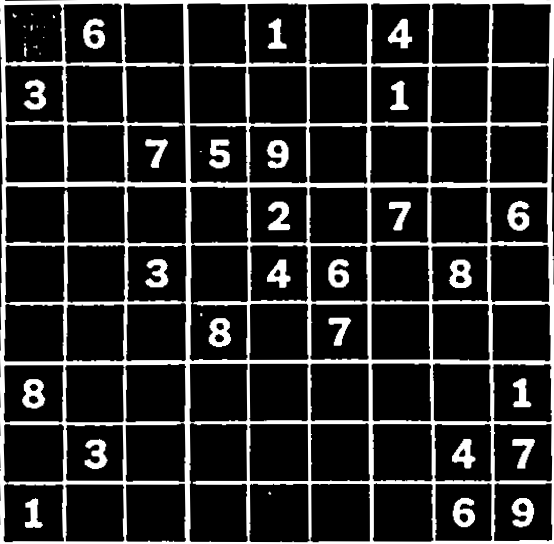

In [ ]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

In [ ]:
BSON.@load "..\\DigitDetection\\outputs\\LeNet5\\LeNet5_e20.bson" model
model(zeros(Float32, (28, 28, 1, 1))) # compile
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

Regions of Interest

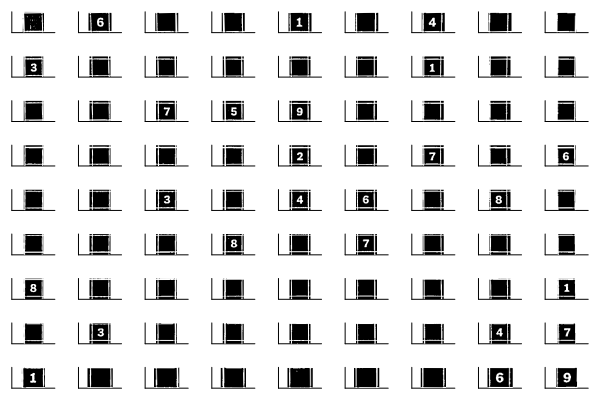

In [ ]:
height, width = size(warped)
step_i = Int(ceil(height / 9))
step_j = Int(ceil(width / 9))
Δoffset = 0.1
offset_i = Int(round(Δoffset * step_i))
offset_j = Int(round(Δoffset * step_j))

RoIs = []
canvases = []
for (i_grid, i_img) in enumerate(1:step_i:height)
    for (j_grid, j_img) in enumerate(1:step_j:width)
        prev_i = max(1, i_img - offset_i)
        prev_j = max(1, j_img - offset_j)
        next_i = min(i_img + step_i + offset_i, height)
        next_j = min(j_img + step_j + offset_j, width)
        RoI = warped[prev_i:next_i, prev_j:next_j]
        canvas = plot(RoI)
        push!(RoIs, RoI)
        push!(canvases, canvas)
    end
end
plot(canvases..., layout=(9, 9), ticks=nothing, border=nothing)

### Single digit test

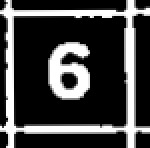

In [ ]:
i, j = 5, 6
RoI = RoIs[(i - 1) * 9 + j]

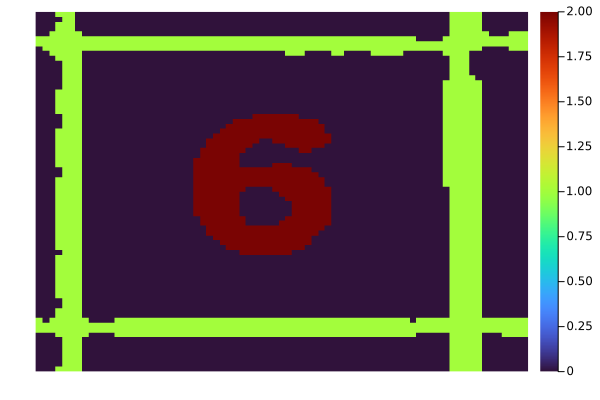

In [ ]:
RoI = binarize(RoI, Otsu()) 
labels = label_components(RoI)
heatmap(labels, yflip=true, c=:turbo, border=:none)

In [ ]:
h = size(RoI, 1)
w = size(RoI, 2)
r =  min(h, w) * 0.25
kernel = make_circle_kernel(h, w, r)
Gray.(kernel .* RoI) 
sum(kernel .* RoI .!= 0)/(pi * r * r)

0.37760062466214467

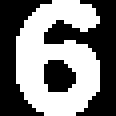

In [ ]:
digit, centre = extract_digit(RoI, threshold=0.1)
digit

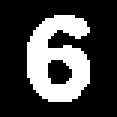

In [ ]:
height, width = size(digit)
pad = floor(Int, 0.2 * max(height, width))
imnew = zeros(Float32, (height + 2pad, width +2pad))
imnew[(pad + 1):(pad + height), (pad + 1):(pad + width)] = digit
digit_ = Gray.(imnew)

In [ ]:
digit_ = imresize(digit_, (28, 28))
x = reshape(Float32.(digit_), 28, 28, 1, 1)
logits = model(x)
probabilites = softmax(logits)
idx = argmax(probabilites)
ŷ = idx[1] - 1
ŷ, probabilites[idx]

(6, 0.99999845f0)

In [ ]:
function predictor(digit_image::AbstractArray)
    logits = digit_image |> DigitExtraction.prepare_digit_for_model |> model
    idx = argmax(logits)
    probabilites = softmax(logits)
    idx[1] - 1, probabilites[idx]
end

predictor (generic function with 1 method)

In [ ]:
predictor(digit)

(6, 0.99999976f0)

## Full grid

25 regions need to be examined


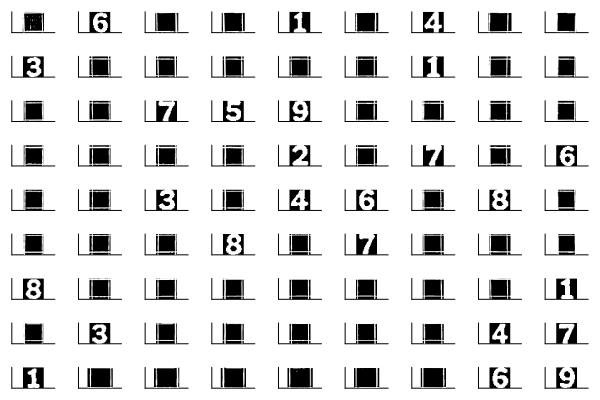

9×9 Matrix{Int64}:
 0  6  0  0  1  0  4  0  0
 3  0  0  0  0  0  1  0  0
 0  0  7  5  9  0  0  0  0
 0  0  0  0  2  0  7  0  6
 0  0  3  0  4  6  0  8  0
 0  0  0  8  0  7  0  0  0
 8  0  0  0  0  0  0  0  1
 0  3  0  0  0  0  0  4  7
 1  0  0  0  0  0  0  6  9

9×9 Matrix{Float32}:
 0.0  1.0  0.0  0.0       1.0  0.0  1.0  0.0      0.0
 1.0  0.0  0.0  0.0       0.0  0.0  1.0  0.0      0.0
 0.0  0.0  1.0  1.0       1.0  0.0  0.0  0.0      0.0
 0.0  0.0  0.0  0.0       1.0  0.0  1.0  0.0      1.0
 0.0  0.0  1.0  0.0       1.0  1.0  0.0  0.99989  0.0
 0.0  0.0  0.0  0.999999  0.0  1.0  0.0  0.0      0.0
 1.0  0.0  0.0  0.0       0.0  0.0  0.0  0.0      1.0
 0.0  1.0  0.0  0.0       0.0  0.0  0.0  1.0      1.0
 1.0  0.0  0.0  0.0       0.0  0.0  0.0  1.0      1.0

In [ ]:
height, width = size(warped)
step_i = Int(ceil(height / 9))
step_j = Int(ceil(width / 9))
Δoffset = 0.1
offset_i = Int(round(Δoffset * step_i))
offset_j = Int(round(Δoffset * step_j))

canvases = []
num_detections = 0

grid = zeros(Int, (9, 9))
centres =  [(-1.0, -1.0) for i in 1:9, j in 1:9]
probabilities = zeros(Float32, (9, 9))

for (i_grid, i_img) in enumerate(1:step_i:height)
    for (j_grid, j_img) in enumerate(1:step_j:width)
        prev_i = max(1, i_img - offset_i)
        prev_j = max(1, j_img - offset_j)
        next_i = min(i_img + step_i + offset_i, height)
        next_j = min(j_img + step_j + offset_j, width)
        RoI = warped[prev_i:next_i, prev_j:next_j]
        if detect_in_centre(RoI)
            num_detections += 1
            digit, centre = extract_digit(RoI)
            label, probability = predictor(digit)
            grid[i_grid, j_grid] =label
            probabilities[i_grid, j_grid] = probability
            canvas = plot(Gray.(digit))
        else
            centre =(step_i/2, step_j/2)
            canvas = plot(RoI)
        end
        centres[i_grid, j_grid] = (centre[1] + prev_i, centre[2] + prev_j)
        push!(canvases, canvas)
        push!(RoIs, RoI)
    end
end
println("$num_detections regions need to be examined")
extracted = plot(canvases..., layout=(9, 9), ticks=nothing, border=nothing)
display(extracted)
display(grid)
display(probabilities)

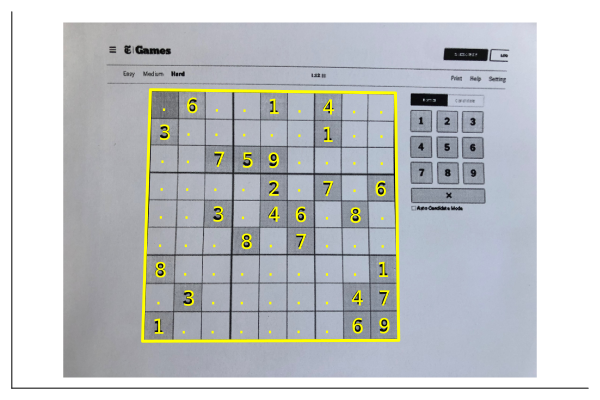

In [ ]:
threshold = 0.95
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=nothing);
plot!(canvas, 
    [point[2] for point in vcat(quad, quad[1])], 
    [point[1] for point in vcat(quad, quad[1])], 
    linewidth=3, label="", color=:yellow
);

for i in 1:9
    for j in 1:9
        centre = centres[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        label =  (probabilities[i, j] > threshold) ? string(grid[i, j]) : "."
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], label, :yellow)
    end
end
canvas